# MMAE 500 - Data Driven Modeling - Final Project

## Jay Steinberg

## 4/27/2023

In [39]:
!pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
### NOTE: Colab requires runtime to be restarted after installing PySINDy ###

In [41]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import io
import pandas as pd

from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.optimize import curve_fit

import pysindy as ps
from pysindy.feature_library import custom_library

In [42]:
# load data from a single test run file
# data = sp.io.loadmat('/content/B2356run6.mat')

# TTC has two general types of tests: cornering and drive/brake combo. Runs 1-49  
# are cornering, runs 50-79 are drive/brake cycle.
# Data is available for all runs as RAW (complete) or RUN (without excess gaps).
# Using RUN data to start with to reduce file size.

# AMBTMP = data['AMBTMP'] # ambient room temp     [C]
# ET = data['ET']         # elapsed time for test [seconds]
# FX = data['FX']         # longitudinal force    [N]
# FY = data['FY']         # lateral force         [N]
# FZ = data['FZ']         # normal load           [N]
# IA = data['IA']         # inclination angle     [degrees]
# MX = data['MX']         # overturning moment    [Nm]
# MZ = data['MZ']         # aligning torque       [Nm]
# N = data['N']           # rotational speed      [rpm]
# NFX = data['NFX']       # normalized (fx/fz)    [unitless]
# NFY = data['NFY']       # normalized (fy/fz)    [unitless]
# P = data['P']           # tire pressure         [kPa]
# RE = data['RE']         # effective radius      [cm]
# RL = data['RL']         # loaded radius         [cm]
# RST = data['RST']       # road surf. temp.      [C]
# SA = data['SA']         # slip angle            [degrees]
# SL = data['SL']         # slip ratio on RE      [unitless]
# SR = data['SR']         # slip ratio on RL      [unitless]
# TSTC = data['TSTC']     # tire surf.temp center [C]
# TSTI = data['TSTI']     # tire s.temp inboard   [C]
# TSTO = data['TSTO']     # tire s.temp outboard  [C]
# V = data['V']           # road speed            [kph]

# x = np.array([ET, AMBTMP, FX, FY, FZ, IA, MX, MZ, N, NFX, NFY, P, RE, RL, RST,
#               SA, SL, SR, TSTC, TSTI, TSTO, V])

# Note: These separate data arrays are no longer used but kept for reference

In [43]:
# Use Pandas to read file into dataframe 
# (simpler code, easier manipulation)

df = pd.read_table('/content/B2356run6.dat', skiprows=[0,2])

# print(df)

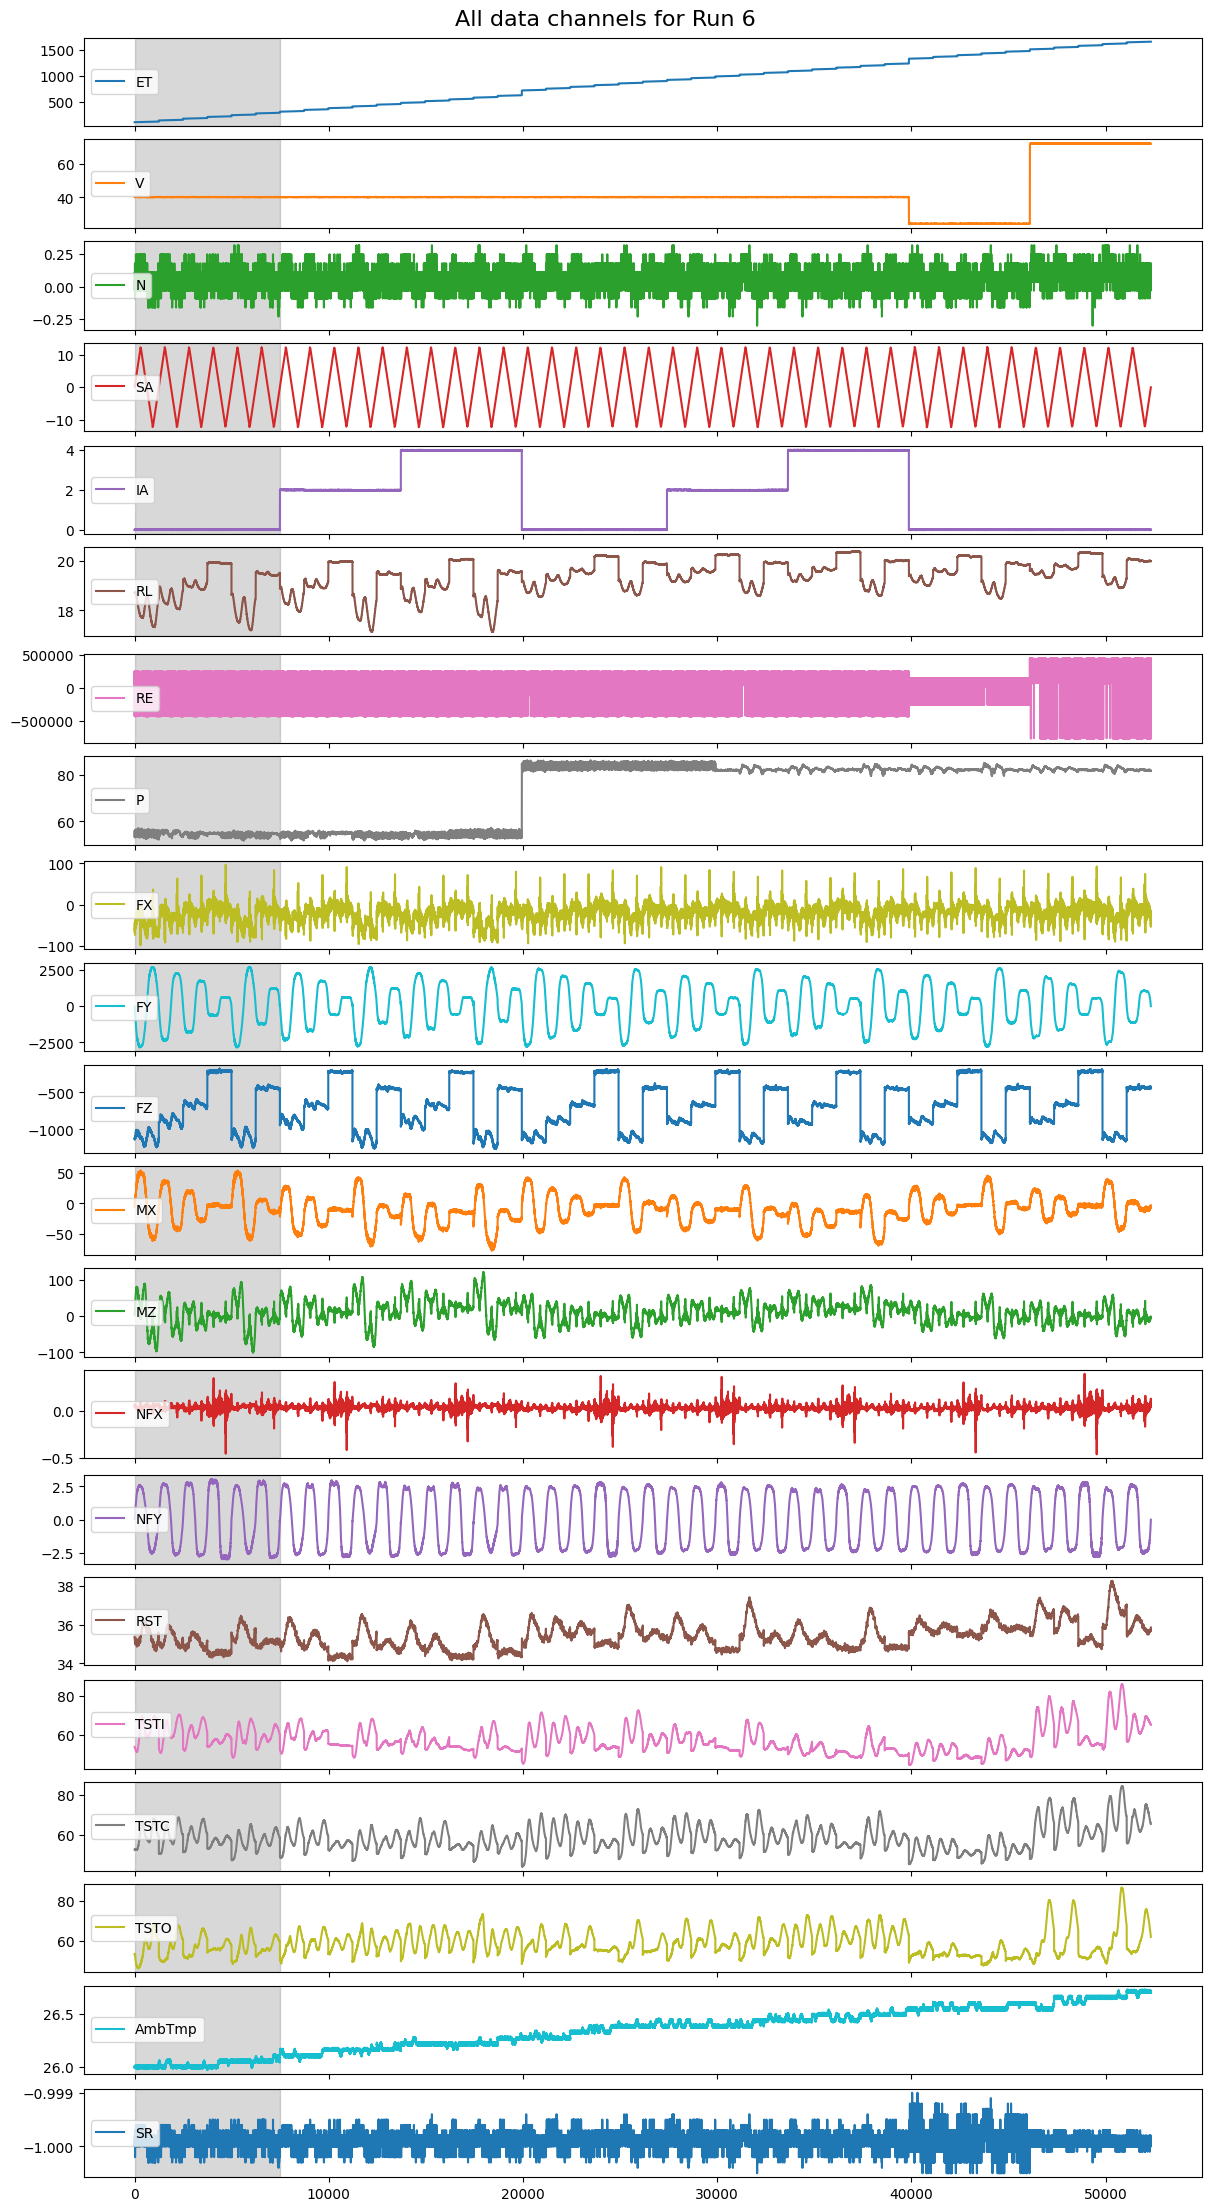

In [44]:
fig, a = plt.subplots(21, figsize=(12,22), constrained_layout=True, sharex=True)
df.plot(ax=a, subplots=True)
for n in range(21):
  a[n].legend(loc="center left")
  a[n].axvspan(0,7500, color='grey', alpha=0.3)
fig.suptitle("All data channels for Run 6", fontsize=16)
plt.show()

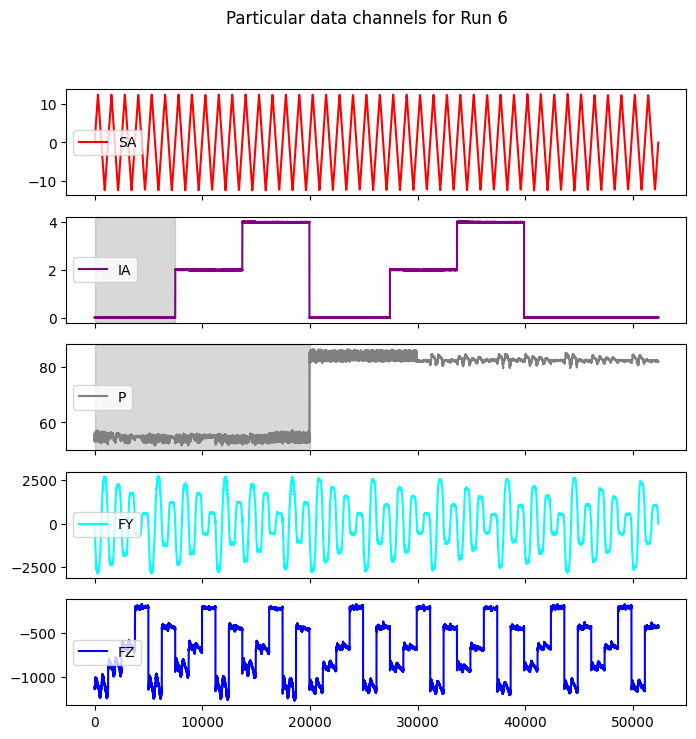

In [45]:
fig, b = plt.subplots(5, figsize=(8,8), sharex=True)
b[0].plot(df.index.values, df['SA'], label='SA', color='red')
b[0].legend(loc="center left")
b[1].plot(df.index.values, df['IA'], label='IA', color='purple')
b[1].legend(loc="center left")
b[1].axvspan(0,7500, color='grey', alpha=0.3)
b[2].plot(df.index.values, df['P'], label='P', color='gray')
b[2].axvspan(0,20000, color='grey', alpha=0.3)
b[2].legend(loc="center left")
b[3].plot(df.index.values, df['FY'], label='FY', color='cyan')
b[3].legend(loc="center left")
b[4].plot(df.index.values, df['FZ'], label='FZ', color='blue')
b[4].legend(loc="center left")
fig.suptitle("Particular data channels for Run 6", fontsize=12)
plt.show()

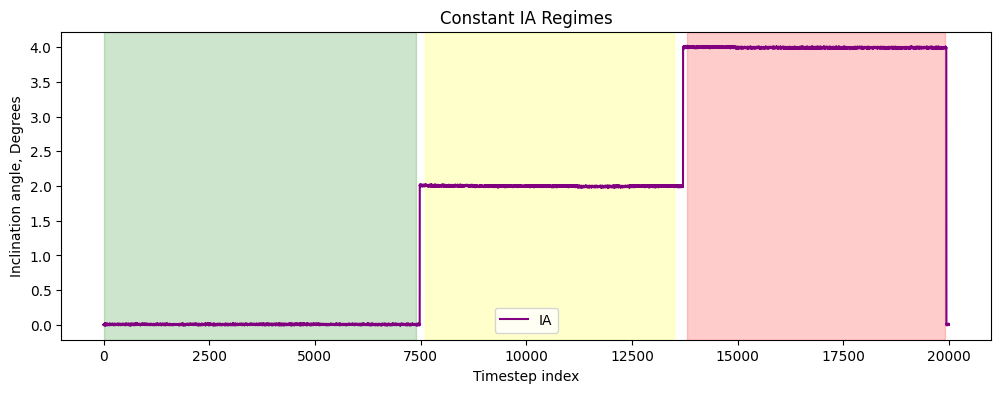

In [46]:
# Suspect we want regions of constant camber and pressure for simple modeling
# Pressure also has a step change around timestep 20000, so consider below that
# for segmenting

dffirst = df[:20000]

plt.figure(figsize=(12,4))
dffirst["IA"].plot(color='purple')
plt.ylabel("Inclination angle, Degrees")
plt.xlabel("Timestep index")
plt.title("Constant IA Regimes")
plt.axvspan(0,7400, color='green', alpha=0.2)
plt.axvspan(7600,13500, color='yellow', alpha=0.2)
plt.axvspan(13800,19900, color='red', alpha=0.2)
plt.legend()
plt.show()

In [47]:
# Since Pacejka model only depends on slip angle at static vertical load FZ,
# create subset dataframes for analyses

# Add a column, change degrees to radians for fit
df["SA_rad"] = df["SA"] * np.pi/180 
#df["SA_rad"].plot()
dffirst["SA_rad"] = dffirst["SA"] * np.pi/180 

# Subsets
# simplest subsets - only FY and SA, only early regimes
subset1 = dffirst[["FY", "SA_rad"]] 

# suspect the normalized FY will work better - elminate FZ normal force as var.
subset1b = dffirst[["NFY", "SA_rad"]]

# comparing Pacejka models need const. FZ 
subset2 = dffirst[["FY", "SA_rad", "FZ"]] 

# Expected most likely interacting features based on tire understanding
subset3 = df[["FY", "SA_rad", "FZ", "IA", "P", "MZ"]]

# Similar to 3 but using Normalized FY (NFY) which looks proportional to SA
subset4 = df[["NFY", "SA_rad", "IA", "P", "MZ"]]

<ipython-input-47-06727c2a1147>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffirst["SA_rad"] = dffirst["SA"] * np.pi/180


Text(0.5, 0.98, 'Checking Data Quality and Correlation for Low IA Regime')

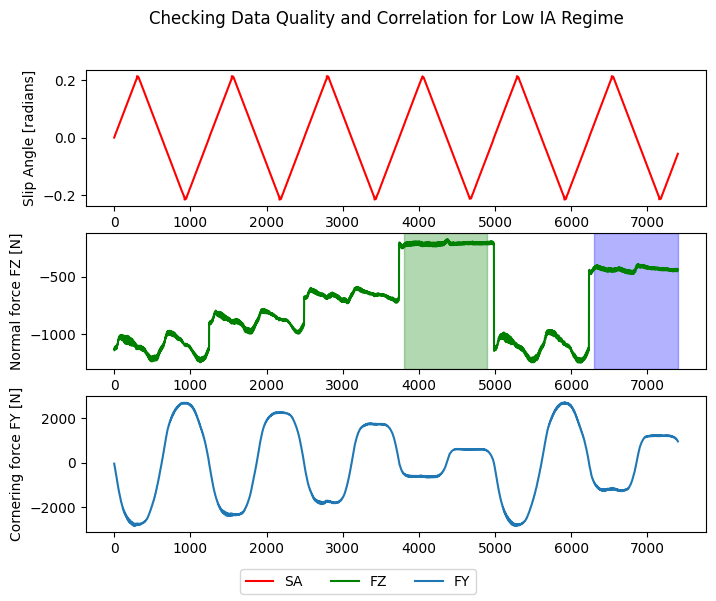

In [48]:
# Smoothing FZ data with pandas rolling average
#df_trim["FZ_s"] = df_trim.FZ.rolling(900).mean()

# Put subset data into regimes based on controlled test criteria / vertical loads
sub1_lowIA = subset1[0:7400]
sub1_midIA = subset1[7600:13500]
sub1_highIA = subset1[13900:19900]

sub2_lowIA = subset2[0:7400]
sub2_midIA = subset2[7600:13500]
sub2_highIA = subset2[13900:19900]

look=sub1_lowIA[:1000]

fig2, ax2 = plt.subplots(3, figsize=(8,6))
ax2[0].plot(sub1_lowIA.index, sub1_lowIA["SA_rad"], color='red', label='SA')
ax2[0].set(ylabel="Slip Angle [radians]")
ax2[1].plot(sub2_lowIA.index, sub2_lowIA["FZ"], color='green', label='FZ')
ax2[1].set(ylabel="Normal force FZ [N]")
ax2[1].axvspan(3800,4900, color='green', alpha=0.3)
ax2[1].axvspan(6300,7400, color='blue', alpha=0.3)
ax2[2].plot(sub1_lowIA.index, sub1_lowIA["FY"], label='FY')
ax2[2].set(ylabel="Cornering force FY [N]")
fig2.legend(loc='lower center', ncol=3)
fig2.suptitle("Checking Data Quality and Correlation for Low IA Regime")

# print(mean_lowFZ)

In [49]:
# Further subsetting of regions of nearly constant normal force FZ.

sub1_lowIA_lowFZ = subset1[3800:4900]
sub1_lowIA_midFZ = subset1[6300:7400]

sub2_lowIA_lowFZ = subset2[3800:4900]
sub2_lowIA_midFZ = subset2[6300:7400]

Text(0.5, 0.98, 'Checking Data Quality and Correlation for Mid IA Regime')

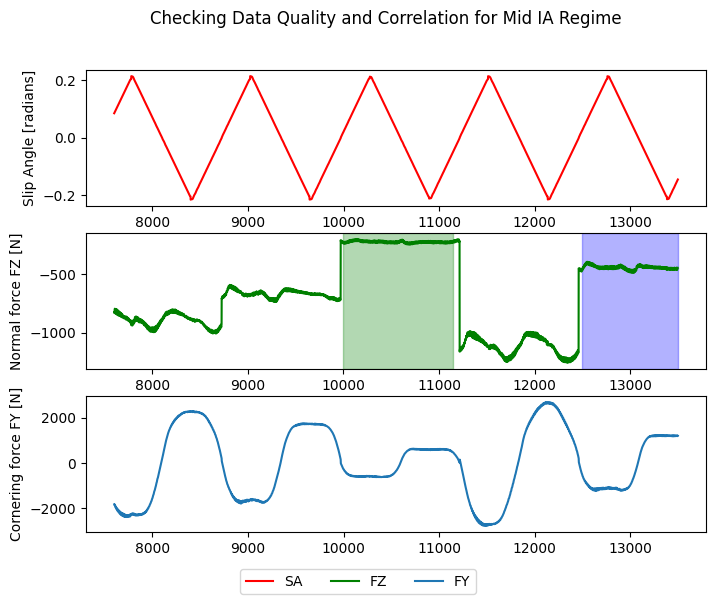

In [50]:
fig2, ax2 = plt.subplots(3, figsize=(8,6))
ax2[0].plot(sub1_midIA.index, sub1_midIA["SA_rad"], color='red', label='SA')
ax2[0].set(ylabel="Slip Angle [radians]")
ax2[1].plot(sub2_midIA.index, sub2_midIA["FZ"], color='green', label='FZ')
ax2[1].set(ylabel="Normal force FZ [N]")
ax2[1].axvspan(10000,11150, color='green', alpha=0.3)
ax2[1].axvspan(12500,13500, color='blue', alpha=0.3)
ax2[2].plot(sub1_midIA.index, sub1_midIA["FY"], label='FY')
ax2[2].set(ylabel="Cornering force FY [N]")
fig2.legend(loc='lower center', ncol=3)
fig2.suptitle("Checking Data Quality and Correlation for Mid IA Regime")

In [51]:
# Further subsetting of regions of nearly constant normal force FZ.

sub1_midIA_lowFZ = subset1[10000:11150]
sub1_midIA_midFZ = subset1[12500:13500]

sub2_midIA_lowFZ = subset2[10000:11150]
sub2_midIA_midFZ = subset2[12500:13500]

Text(0.5, 0.98, 'Checking Data Quality and Correlation for High IA Regime')

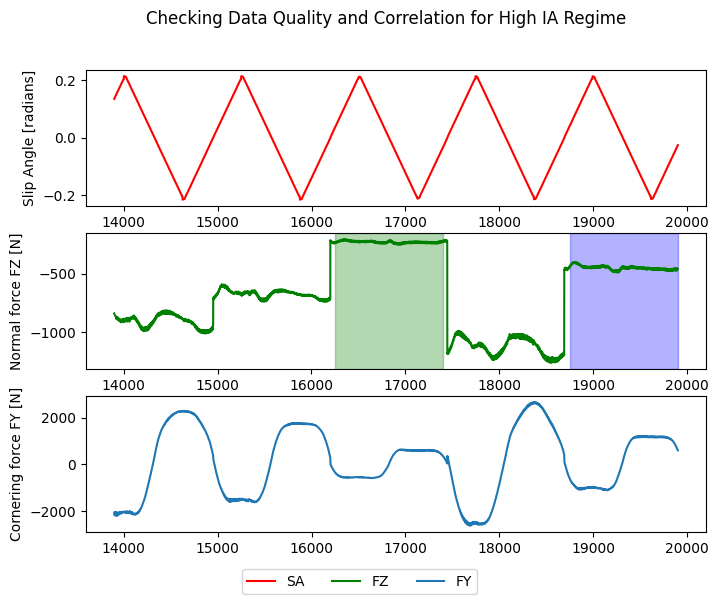

In [52]:
#sub2_highIA = subset2[13900:19900]

fig2, ax2 = plt.subplots(3, figsize=(8,6))
ax2[0].plot(sub1_highIA.index, sub1_highIA["SA_rad"], color='red', label='SA')
ax2[0].set(ylabel="Slip Angle [radians]")
ax2[1].plot(sub2_highIA.index, sub2_highIA["FZ"], color='green', label='FZ')
ax2[1].set(ylabel="Normal force FZ [N]")
ax2[1].axvspan(16250,17400, color='green', alpha=0.3)
ax2[1].axvspan(18750,19900, color='blue', alpha=0.3)
ax2[2].plot(sub1_highIA.index, sub1_highIA["FY"], label='FY')
ax2[2].set(ylabel="Cornering force FY [N]")
fig2.legend(loc='lower center', ncol=3)
fig2.suptitle("Checking Data Quality and Correlation for High IA Regime")

In [53]:
# Further subsetting of regions of nearly constant normal force FZ.

sub1_highIA_lowFZ = subset1[16250:17400]
sub1_highIA_midFZ = subset1[18750:19900]

sub2_highIA_lowFZ = subset2[16250:17400]
sub2_highIA_midFZ = subset2[18750:19900]

In [54]:
# Early modeling - Fit a Pacejka model to this particular tire/run for baseline

# Pacejka "magic formula": 
# Y(X) = D*sin(C*atan(B*x - E*(B*x-atan(B*x))))

# where Y(X) is the parameter of interest: cornering force FY, longitudinal 
# force FX, or aligning moment MZ

# Using data from pure cornering test runs, so interested in lateral force FY
# as a function of slip angle SA. This requires a constant FZ normal force.

# Literature suggests to use C=1.3 for lateral force FY fit
C_given = 1.3

def pacejka(X, B, D, E):
  return D*np.sin(C_given*np.arctan(B*X - E*(B*X-np.arctan(B*X))))

pars_low, cov_low = curve_fit(f=pacejka, xdata=sub1_lowIA_lowFZ["SA_rad"], 
                              ydata=sub1_lowIA_lowFZ["FY"], p0=[1, 1, 1])

pars_low2, cov_low2 = curve_fit(f=pacejka, xdata=sub1_lowIA_midFZ["SA_rad"], 
                              ydata=sub1_lowIA_midFZ["FY"], p0=[1, 1, 1])

pars_mid, cov_mid = curve_fit(f=pacejka, xdata=sub1_midIA_midFZ["SA_rad"], 
                              ydata=sub1_midIA_midFZ["FY"], p0=[4, 4, 1])

pars_high, cov_high = curve_fit(f=pacejka, xdata=sub1_highIA_midFZ["SA_rad"], 
                              ydata=sub1_highIA_midFZ["FY"], p0=[6, 5, 4])



In [55]:
#check cov

print("Fit Check - covariances:")
print("\nLow IA / Low FZ:\n", cov_low)
print("\nLow IA / Mid FZ:\n", cov_low2)
print("\nMid IA / Mid FZ:\n", cov_mid)
print("\nHigh IA / Mid FZ:\n", cov_high)
print("\n\nNote some very high variances")

Fit Check - covariances:

Low IA / Low FZ:
 [[ 1.10682974e+05 -7.60071119e+01  3.69023377e+06]
 [-7.60071119e+01  1.45472254e+01 -2.53956304e+03]
 [ 3.69023377e+06 -2.53956304e+03  1.23148732e+08]]

Low IA / Mid FZ:
 [[1.43153624e-03 3.67846367e-03 3.79838205e+08]
 [3.67846367e-03 1.92542718e+01 9.85285063e+08]
 [3.79838205e+08 9.85285063e+08 1.00788855e+20]]

Mid IA / Mid FZ:
 [[1.20815219e-03 2.83195810e-04 3.36348845e+08]
 [2.83195810e-04 2.41555452e+01 1.15102826e+08]
 [3.36348845e+08 1.15102826e+08 9.36427090e+19]]

High IA / Mid FZ:
 [[ 4.23508953e-04  1.54771131e-03 -2.33851692e+08]
 [ 1.54771131e-03  2.54086523e+01 -9.23683564e+08]
 [-2.33851692e+08 -9.23683564e+08  1.29138063e+20]]


Note some very high variances


In [56]:
# print coefficients of Pacejka model fits for low, mid, high loads

coeffs = np.zeros([3,4])
coeffs[:,0] = pars_low.T
coeffs[:,1] = pars_low2.T
coeffs[:,2] = pars_mid.T
coeffs[:,3] = pars_high.T

print("Coefficients of Pacejka models (B,D,E):\n", "Low IA/Low FZ\t  ", 
      "Low IA/Mid FZ   ", "Mid IA/Mid FZ   ", "High IA/Mid FZ\n",coeffs)

Coefficients of Pacejka models (B,D,E):
 Low IA/Low FZ	   Low IA/Mid FZ    Mid IA/Mid FZ    High IA/Mid FZ
 [[-9.95912205e+01 -2.42225599e-02 -2.32597765e-02  1.91543684e-02]
 [-6.32310079e+02 -1.26286124e+03 -1.23017337e+03  1.15124294e+03]
 [ 1.21452614e+03  2.14513147e+09  2.15869545e+09  3.53209865e+09]]


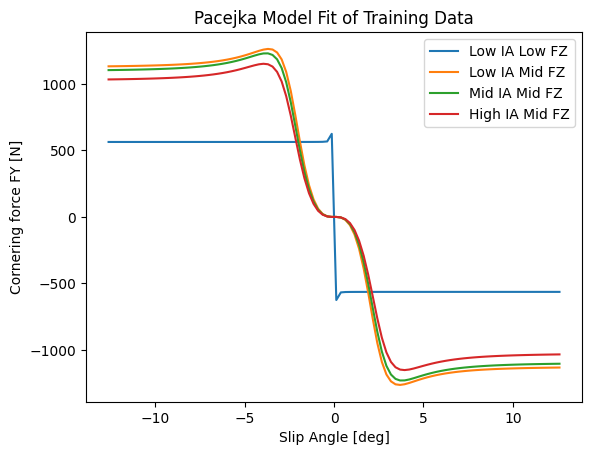

In [57]:
# plot a sample of the Pacejka model fit here, FY versus slip angle

sa_sample = np.linspace(-0.22, 0.22, 100) # slip angles between +/- 0.1 radians
sa_sample_deg = sa_sample * 180 / np.pi # converted to degrees for viewing only
fy_low = pacejka(sa_sample, *coeffs[:,0]) 
fy_low2 = pacejka(sa_sample, *coeffs[:,1]) 
fy_mid = pacejka(sa_sample, *coeffs[:,2])
fy_high = pacejka(sa_sample, *coeffs[:,3])

# print(np.shape(sa_sample))
# print(np.shape(mz_pacejka))

plt.figure()
plt.plot(sa_sample_deg, fy_low, label='Low IA Low FZ')
plt.plot(sa_sample_deg, fy_low2, label='Low IA Mid FZ')
plt.plot(sa_sample_deg, fy_mid, label='Mid IA Mid FZ')
plt.plot(sa_sample_deg, fy_high, label='High IA Mid FZ')
plt.xlabel("Slip Angle [deg]")
plt.ylabel("Cornering force FY [N]")
plt.title("Pacejka Model Fit of Training Data")
plt.legend()


In [58]:
# This isn't a particularly ideal Pacejka cornering model fit as seen in some 
# literature, and the covariance from the scipy curve_fit tool, but it does
# show the expected peaking behavior off center, and typical relationships

# Since this project's scope is looking at alternative considerations
# for tire dynamics, not a manual curve fit, let's move on to SINDy.

## SINDy 

In [59]:
# First: Try a SINDy model fit directly to the complete (trimmed) data

model = ps.SINDy(feature_names=df.columns)

model.fit(df.values, t=df["ET"].to_numpy(), quiet=True)
model.print()

(ET)' = 0.000
(V)' = 8.499 N + 10.695 SA + -218.546 RL + -7.493 P + 7.501 FX + 6.208 MX + -1.726 MZ + 3651.757 NFX + 118.087 RST + -34.968 TSTI + 24.444 TSTC + 46.021 AmbTmp + -0.893 N^2 + 0.438 N RL + 2.987 N NFX + -0.645 N AmbTmp + 10.695 SA SR + -0.471 RL NFX + -218.572 RL SR + -7.494 P SR + 7.502 FX SR + 6.208 MX SR + -1.726 MZ SR + 1.457 NFX^2 + -0.168 NFX NFY + 1.639 NFX AmbTmp + 3685.251 NFX SR + 118.110 RST SR + -34.970 TSTI SR + 24.443 TSTC SR + 46.020 AmbTmp SR
(N)' = -23.658 V + -25.448 SA + 15.749 IA + -33.598 RL + -0.565 P + 0.437 FX + 0.372 FY + -6.503 MZ + 36.571 NFY + 18.591 RST + -7.791 TSTI + 15.256 TSTO + -23.659 V SR + 7.376 N^2 + 2.471 N NFX + -25.449 SA SR + -0.151 IA NFX + 15.746 IA SR + 0.206 RL NFX + -33.608 RL SR + -0.565 P SR + -0.208 FX NFY + 0.305 FX SR + 0.208 FY NFX + -0.135 FZ NFX + -0.372 FZ NFY + -6.503 MZ SR + -0.342 NFX^2 + 0.144 NFX NFY + -1.211 NFX RST + 1.427 NFX AmbTmp + 36.576 NFY SR + 18.596 RST SR + -7.792 TSTI SR + 15.258 TSTO SR
(SA)' = -4.2

In [60]:
# Far too many coefficients - this is clearly not sparse.
# Try using dataframe row index for timestep rather than Elapsed Time (ET)
# value from test data

model2 = ps.SINDy(feature_names=df.columns)
model2.fit(df.values, t=df.index.values, quiet=True)
model2.print()



(ET)' = -5.049 V + 91.864 IA + 1.239 P + 4.309 FX + 4.377 MX + -4.466 MZ + -22.350 NFY + 53.447 RST + 15.714 TSTI + -101.598 AmbTmp + -5.050 V SR + -0.118 IA NFX + 91.886 IA SR + 1.828 RL NFX + 1.239 P SR + 4.080 FX SR + -0.235 FZ NFX + 4.378 MX SR + -4.467 MZ SR + -1.257 NFX RST + 0.230 NFX AmbTmp + -22.354 NFY SR + 53.461 RST SR + 15.717 TSTI SR + -101.626 AmbTmp SR
(V)' = -4.945 RL + 2.410 RST + 0.118 N NFX + -4.946 RL SR + 2.410 RST SR
(N)' = 0.000
(SA)' = -6.167 NFY + -26.507 RST + -11.250 TSTO + 60.056 AmbTmp + 0.022 N NFX + -6.170 NFY SR + -26.483 RST SR + -11.252 TSTO SR + 60.028 AmbTmp SR
(IA)' = 0.000
(RL)' = 0.000
(RE)' = 5812531040.612 1 + 94013.669 ET + -2125237.065 V + 310893307.643 N + -19268599.745 SA + 43540763.270 IA + -89447900.970 RL + 109.091 RE + 1058648.300 P + 1531559.768 FX + 65977.691 FY + 108588.621 FZ + 2376554.470 MX + -2634729.911 MZ + 617846437.238 NFX + 72781458.841 NFY + -3169698.709 RST + -4854407.228 TSTI + 4053182.550 TSTC + -753220.570 TSTO + 420231

In [61]:
# This looks a bit more sparse but still have a lot of terms for each. 
# Our interest is in predicting FX, FY, MZ so let's try some ways of reducing 
# the possible interactions.

# Consider the same model (model2) but use the SR3 optimizer

sr3_optimizer = ps.SR3(trimming_fraction=0.1)
model3 = ps.SINDy(optimizer=sr3_optimizer, feature_names=df.columns) 
model3.fit(df.values, t=df.index.values, quiet=True)
print("With trimming:")
model3.print()

With trimming:
(ET)' = 7.282 SA + 23.938 IA + -4.417 RL + -2.496 MZ + -27.260 NFY + -0.012 N^2 + -0.043 N RL + -1.609 N NFX + 0.026 N RST + 7.278 SA SR + -0.173 IA NFX + -0.015 IA AmbTmp + 23.568 IA SR + 0.001 RL^2 + 1.146 RL NFX + -0.002 RL NFY + -4.406 RL SR + -0.005 FZ NFX + 0.001 MX SR + -2.497 MZ SR + 0.115 NFX^2 + 0.024 NFX NFY + -1.449 NFX RST + -0.044 NFX TSTC + -0.005 NFX TSTO + 1.120 NFX AmbTmp + -27.289 NFY SR + 0.001 TSTC SR
(V)' = 0.000
(N)' = 0.000
(SA)' = 0.000
(IA)' = 0.000
(RL)' = 0.000
(RE)' = 4878018505.178 1 + 92401.668 ET + -2106116.259 V + 316347565.716 N + -19292515.053 SA + 43007374.742 IA + -91109097.055 RL + 111.256 RE + 1182435.203 P + 1536180.811 FX + 63184.596 FY + 112000.091 FZ + 2197572.279 MX + -2621420.301 MZ + 587511940.204 NFX + 72153684.699 NFY + -2807192.774 RST + -4904675.380 TSTI + 4118401.851 TSTC + -721032.866 TSTO + 39354561.891 AmbTmp + 8924145666.583 SR + -338524.334 SA_rad + -0.229 ET V + -6.197 ET N + 5.631 ET SA + -17.789 ET IA + 3.777 ET 

In [62]:
# that seems to be even less sparse in MZ' and FY'
# Let's add some custom library functions such as those used in the Pacejka 
# model, including arctan, sin, etc.

functions = [lambda x : np.sin(x), 
             lambda x : np.arctan(x), 
             lambda x : np.cos(x), 
             lambda x,y : np.sin(x+y), 
             lambda x,y : np.arctan(x+y), 
             lambda x:x, 
             lambda x,y :x*y, 
             lambda x:x**2]
names = [lambda x: "sin("+x+")", 
         lambda x: "arctan("+x+")", 
         lambda x: "cos("+x+")", 
         lambda x,y: "sin("+x+"+"+y+")", 
         lambda x,y: "arctan("+x+"+"+y+")", 
         lambda x: "("+x+")", 
         lambda x,y: "("+x+"*"+y+")",
         lambda x: "("+x+"**2)"]
lib = custom_library.CustomLibrary(library_functions=functions, 
                                   function_names=names).fit(df.values)
lib.transform(df.values)
# lib.get_feature_names()

model4 = ps.SINDy(feature_names=df.columns, feature_library=lib)
model4.fit(df.values, t=df.index.values, quiet=True)
model4.print()

(ET)' = 0.214 sin(SA) + 0.488 sin(RL) + 29.188 sin(MX) + -60.065 sin(NFX) + -0.124 sin(TSTC) + 1.031 sin(AmbTmp) + -0.673 arctan(N) + -87.474 arctan(SA) + 2.311 arctan(IA) + 5201.461 arctan(FY) + -94183.186 arctan(FZ) + 0.653 arctan(MZ) + 55.466 arctan(NFX) + -18.886 arctan(NFY) + 6892.274 arctan(TSTI) + -3929.307 arctan(TSTC) + 2743.111 arctan(TSTO) + -2.984 cos(IA) + -45.438 cos(MX) + -0.170 cos(NFY) + 0.507 cos(TSTO) + -3.169 cos(AmbTmp) + -0.116 sin(V+N) + 0.104 sin(V+NFX) + -0.334 sin(N+IA) + 4.539 sin(N+NFX) + 0.305 sin(N+RST) + 0.308 sin(N+AmbTmp) + -0.215 sin(SA+NFX) + 3.147 sin(IA+NFX) + -3.959 sin(IA+SR) + -0.487 sin(RL+NFX) + -53.999 sin(MX+SR) + -0.278 sin(NFX+RST) + 0.129 sin(NFX+TSTC) + -0.334 sin(NFX+TSTO) + 0.064 sin(NFY+SA_rad) + 0.594 sin(TSTO+SR) + -0.134 sin(AmbTmp+SA_rad) + -0.312 arctan(ET+FX) + 3.128 arctan(ET+MX) + 1.770 arctan(V+SA) + 0.410 arctan(V+FY) + -90.939 arctan(V+FZ) + -0.857 arctan(N+SA) + 0.530 arctan(N+IA) + 15.327 arctan(N+FY) + 9021.321 arctan(N+F

In [63]:
# Far too busy - the previous cell took nearly 3min to run. 

## FY SINDy trial with subset data - only FY depending on SA, with FZ as a control

In [64]:
# Now let's see if we can use a comparison SINDy model to find a similar fit 
# to the Pacejka by just relating FY and SA with the standard SINDy library 
# functions

compmodel = ps.SINDy(feature_names=subset1.columns)
compmodel.fit(subset1.values, t=subset1.index.values, quiet=True)
compmodel.print()
comp_coef = compmodel.coefficients()
print(comp_coef)

(FY)' = 0.699 SA_rad + -2.602 SA_rad^2
(SA_rad)' = 0.000
[[ 0.          0.          0.69921798  0.          0.         -2.60205686]
 [ 0.          0.          0.          0.          0.          0.        ]]


In [65]:
# Let's have a look at how this simple model stacks up to the Pacejka fit.

# locate initial value for odeint

init = sub1_lowIA_midFZ.iloc[[0]]
x0 = init['SA_rad']
y0 = init['FY']


Text(0, 0.5, 'FY [N]')

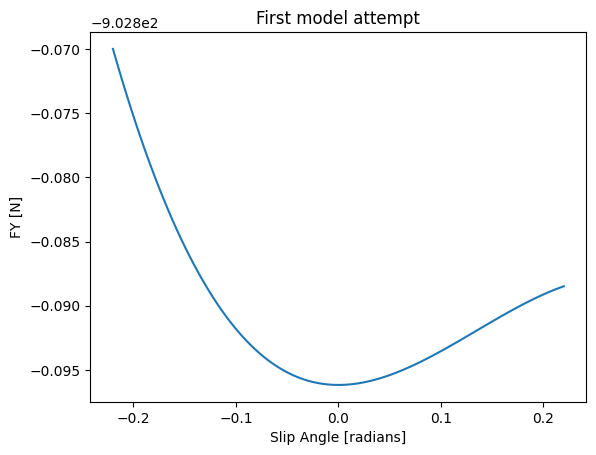

In [66]:
def FY_prime1(FY, SA_radians):
  dFYdt = comp_coef[0,2] * SA_radians + comp_coef[0,5] * SA_radians**2
  return dFYdt

t = np.linspace(-0.22,0.22,100)
res = sp.integrate.odeint(FY_prime1, y0, t)

plt.figure()
plt.title("First model attempt")
plt.plot(sa_sample, res)
plt.xlabel("Slip Angle [radians]")
plt.ylabel("FY [N]")
#plt.plot(sa_sample, FY_prime(1, sa_sample))

# This model does not accurately capture the rotational-symmetric behavior
# of steering left and right

In [67]:
# Interesting - let's try with a custom library of functions such as those used
# in the Pacejka model, including arctan, sin, etc. on just the subset data

functions = [lambda x : np.sin(x), 
             lambda x : np.arctan(x), 
             lambda x : np.cos(x), 
             lambda x,y : np.sin(x+y), 
             lambda x,y : np.arctan(x+y), 
             lambda x:x, 
             lambda x,y :x*y, 
             lambda x:x**2]
names = [lambda x: "sin("+x+")", 
         lambda x: "arctan("+x+")", 
         lambda x: "cos("+x+")", 
         lambda x,y: "sin("+x+"+"+y+")", 
         lambda x,y: "arctan("+x+"+"+y+")", 
         lambda x: "("+x+")", 
         lambda x,y: "("+x+"*"+y+")",
         lambda x: "("+x+"**2)"]
lib = custom_library.CustomLibrary(library_functions=functions, 
                                   function_names=names).fit(subset1.values)
lib.transform(subset1.values)
# lib.get_feature_names()

compmodel2 = ps.SINDy(feature_names=subset1.columns, feature_library=lib)
compmodel2.fit(subset1.values, t=subset1.index.values, quiet=True)
compmodel2.print()
comp2_coef = compmodel2.coefficients()
print(comp2_coef)

(FY)' = 0.555 sin(FY) + -129250.796 sin(SA_rad) + 1531.069 arctan(FY) + 67439.175 arctan(SA_rad) + -0.708 sin(FY+SA_rad) + -1530.163 arctan(FY+SA_rad) + 61837.177 (SA_rad) + -2.575 (SA_rad**2)
(SA_rad)' = 0.000
[[ 5.55247323e-01 -1.29250796e+05  1.53106903e+03  6.74391750e+04
   0.00000000e+00  0.00000000e+00 -7.07764015e-01 -1.53016337e+03
   0.00000000e+00  6.18371773e+04  0.00000000e+00  0.00000000e+00
  -2.57501424e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


Text(0, 0.5, 'FY [N]')

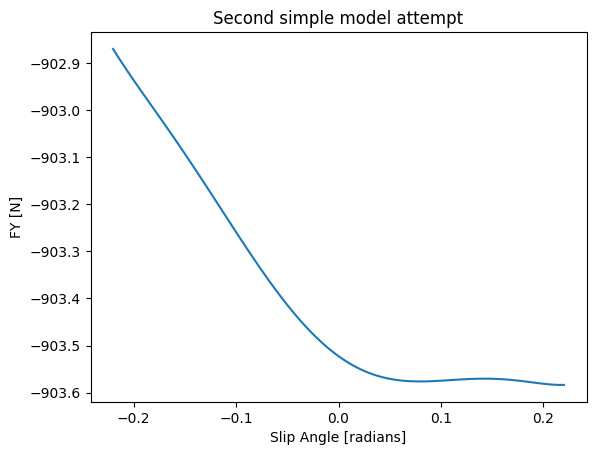

In [68]:
# Let's plot this attempt

def FY_prime2(FY, SA):
  dFYdt = (comp2_coef[0,0] * np.sin(FY) + comp2_coef[0,1] * np.sin(SA) +
          comp2_coef[0,2] * np.arctan(FY) + comp2_coef[0,3] * np.arctan(SA) + 
          comp2_coef[0,6] * np.sin(FY+SA) + comp2_coef[0,7] * np.arctan(FY+SA) +
          comp2_coef[0,9] * SA + comp2_coef[0,12] * (SA**2))
  return dFYdt

t = np.linspace(-0.22,0.22,100)
res2 = sp.integrate.odeint(FY_prime2, y0, t)

plt.figure()
plt.plot(sa_sample, res2)
plt.title("Second simple model attempt")
plt.xlabel("Slip Angle [radians]")
plt.ylabel("FY [N]")
#plt.plot(sa_sample, FY_prime2(1, sa_sample))

In [69]:
# Still not great. Let's look at subset 1b - using SA and normalized FY (NFY)

compmodel3 = ps.SINDy(optimizer=sr3_optimizer, feature_names=subset1b.columns)
compmodel3.fit(subset1b.values, t=subset1b.index.values, quiet=True)
compmodel3.print()
comp_coef3 = compmodel3.coefficients()
print(comp_coef3)

(NFY)' = 0.000
(SA_rad)' = 0.000
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [70]:
# similar to above but using custom library functions


compmodel3c = ps.SINDy(feature_names=subset1b.columns, feature_library=lib)
compmodel3c.fit(subset1b.values, t=subset1b.index.values, quiet=True)
compmodel3c.print()

(NFY)' = 0.000
(SA_rad)' = 0.000


In [71]:
# trial with subset 3

compmodel4 = ps.SINDy(feature_names=subset3.columns)
compmodel4.fit(subset3.values, t=subset3.index.values, quiet=True)
compmodel4.print()
comp_coef4 = compmodel4.coefficients()
#print(comp_coef5)

(FY)' = 0.757 SA_rad + -1.638 SA_rad^2
(SA_rad)' = 0.000
(FZ)' = 0.214 1 + 0.151 SA_rad + -12.763 SA_rad^2
(IA)' = 0.000
(P)' = 0.000
(MZ)' = 0.000


In [72]:
# Subset 3 with custom library functions

compmodel4c = ps.SINDy(feature_names=subset3.columns, feature_library=lib)
compmodel4c.fit(subset3.values, t=subset3.index.values, quiet=True)
compmodel4c.print()

(FY)' = 0.219 sin(FY) + -263455.646 sin(SA_rad) + -160.553 sin(IA) + -2.774 sin(P) + -0.156 sin(MZ) + -1440.241 arctan(FY) + 137340.520 arctan(SA_rad) + 132461.530 arctan(FZ) + 3627.192 arctan(IA) + -8651.233 arctan(P) + -7.776 arctan(MZ) + -94.887 cos(SA_rad) + -838.386 cos(IA) + -0.173 cos(P) + -0.217 sin(FY+SA_rad) + -5.855 sin(SA_rad+IA) + 2.924 sin(SA_rad+P) + 0.194 sin(SA_rad+MZ) + -0.225 sin(P+MZ) + 1446.516 arctan(FY+SA_rad) + 1.113 arctan(FY+FZ) + -5.905 arctan(FY+IA) + 0.676 arctan(FY+P) + -0.928 arctan(FY+MZ) + -184523.289 arctan(SA_rad+FZ) + 10.820 arctan(SA_rad+IA) + 9072.601 arctan(SA_rad+P) + 8.154 arctan(SA_rad+MZ) + 58116.766 arctan(FZ+IA) + 742.302 arctan(FZ+P) + -7525.874 arctan(FZ+MZ) + -556.293 arctan(IA+P) + -0.596 arctan(IA+MZ) + 0.582 arctan(P+MZ) + 126155.799 (SA_rad) + -3479.798 (IA) + 1.373 (SA_rad*IA) + -0.249 (SA_rad*MZ) + -65.713 (SA_rad**2) + 474.003 (IA**2)
(SA_rad)' = 0.000
(FZ)' = 146.991 sin(IA) + 15352.130 arctan(FY) + -168.205 arctan(SA_rad) + 21989

In [73]:
# subset 4

compmodel5 = ps.SINDy(feature_names=subset4.columns)
compmodel5.fit(subset4.values, t=subset4.index.values, quiet=True)
compmodel5.print()
comp_coef5 = compmodel5.coefficients()
#print(comp_coef5)

(NFY)' = 0.000
(SA_rad)' = 0.000
(IA)' = 0.000
(P)' = 0.000
(MZ)' = 0.000


In [74]:
# Subset 4 with custom library functions

compmodel5c = ps.SINDy(feature_names=subset4.columns, feature_library=lib)
compmodel5c.fit(subset4.values, t=subset4.index.values, quiet=True)
compmodel5c.print()
comp_coef5c = compmodel5c.coefficients()
print(comp_coef5c[0,:])

(NFY)' = 0.156 sin(NFY) + -0.157 arctan(SA_rad) + -0.147 sin(NFY+SA_rad)
(SA_rad)' = 0.000
(IA)' = 0.000
(P)' = 0.000
(MZ)' = -8.512 sin(NFY) + 14261.418 sin(SA_rad) + 6.052 sin(IA) + -0.350 sin(P) + 38.162 arctan(NFY) + -7443.110 arctan(SA_rad) + -93.769 arctan(IA) + -0.694 arctan(MZ) + -31.330 cos(SA_rad) + 22.589 cos(IA) + 8.619 sin(NFY+SA_rad) + 0.322 sin(SA_rad+P) + -38.224 arctan(NFY+SA_rad) + 150.110 arctan(NFY+P) + -155.392 arctan(SA_rad+P) + 0.703 arctan(SA_rad+MZ) + 10.897 arctan(IA+P) + -6808.426 (SA_rad) + 88.739 (IA) + 0.158 (NFY*SA_rad) + -17.651 (SA_rad**2) + -11.793 (IA**2)
[ 0.15610437  0.          0.          0.          0.          0.
 -0.15699469  0.          0.          0.          0.          0.
  0.          0.          0.         -0.14737042  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         

Text(0, 0.5, 'FY [N]')

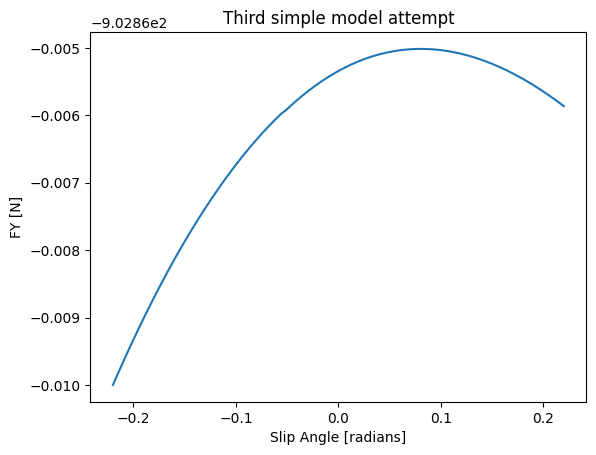

In [75]:
def FY_prime3(NFY, SA):
  dFYdt = (comp_coef5c[0,0] * np.sin(NFY) + comp_coef5c[0,6] * np.arctan(SA) 
          + comp_coef5c[0,15] * np.sin(NFY + SA))
  return dFYdt

#t = np.linspace(-0.22,0.22,100)
res3 = sp.integrate.odeint(FY_prime3, y0, t)

plt.figure()
plt.plot(sa_sample, res3)
plt.title("Third simple model attempt")
plt.xlabel("Slip Angle [radians]")
plt.ylabel("FY [N]")

## Basic alternative curve fitting attempts

<Figure size 640x480 with 0 Axes>

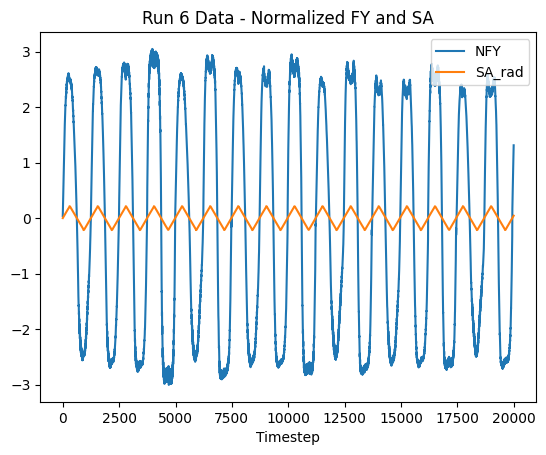

In [76]:
# we might find a simpler solution using a standard curve fit for subset 1b.
plt.figure()
subset1b.plot()
plt.title("Run 6 Data - Normalized FY and SA")
plt.xlabel('Timestep')
plt.show()

[16.41889008 -0.04789062]


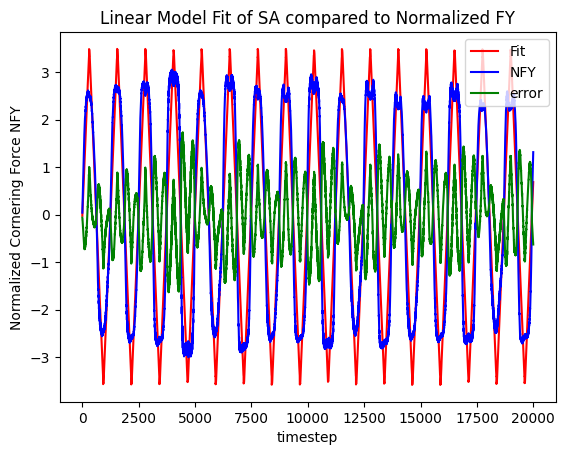

In [77]:
def linear(SA, a, b):
  output = a*SA + b
  return output


pars_lin, cov_lin = curve_fit(f=linear, xdata=subset1b["SA_rad"], 
                              ydata=subset1b["NFY"], p0=[1, 1])

print(pars_lin)

y_lin = linear(sa_sample, *pars_lin)
y_real = linear(subset1b["SA_rad"], *pars_lin)
error_lin = y_real - subset1b["NFY"]

plt.figure()
plt.plot(subset1b.index.values, y_real, label='Fit', color='red')
plt.plot(subset1b.index.values, subset1b["NFY"], label="NFY", color='blue')
plt.plot(subset1b.index.values, error_lin, label="error", color='green')
plt.xlabel("timestep")
plt.ylabel("Normalized Cornering Force NFY")
plt.title("Linear Model Fit of SA compared to Normalized FY")
plt.legend()

[ 2.74446751e+00  1.03368639e+01 -3.03747864e-03]


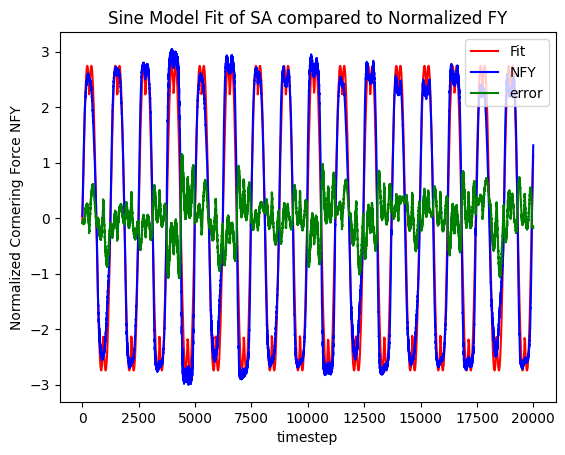

In [78]:
def sine(SA, a, b, c):
  output = a * np.sin(b*(SA + c))
  return output


pars_sine, cov_sine = curve_fit(f=sine, xdata=subset1b["SA_rad"], 
                              ydata=subset1b["NFY"], p0=[1, 1, 1])

print(pars_sine)

ys_lin = sine(sa_sample, *pars_sine)
ys_real = sine(subset1b["SA_rad"], *pars_sine)
error_sine = ys_real - subset1b["NFY"]


plt.figure()
plt.plot(subset1b.index.values, ys_real, label='Fit', color='red')
plt.plot(subset1b.index.values, subset1b["NFY"], label="NFY", color='blue')
plt.plot(subset1b.index.values, error_sine, label="error", color='green')
plt.xlabel("timestep")
plt.ylabel("Normalized Cornering Force NFY")
plt.title("Sine Model Fit of SA compared to Normalized FY")
plt.legend()

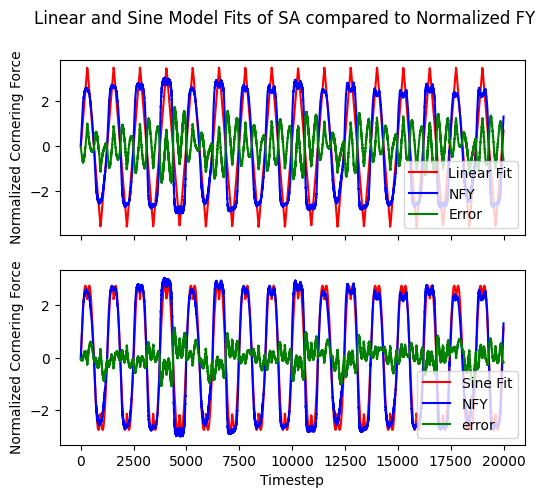

In [79]:
fig, c = plt.subplots(2, figsize=(6,5), sharex=True)
c[0].plot(subset1b.index.values, y_real, label='Linear Fit', color='red')
c[0].plot(subset1b.index.values, subset1b["NFY"], label="NFY", color='blue')
c[0].plot(subset1b.index.values, error_lin, label="Error", color='green')
c[0].set(ylabel="Normalized Cornering Force")
c[0].legend(loc='lower right')
c[1].plot(subset1b.index.values, ys_real, label='Sine Fit', color='red')
c[1].plot(subset1b.index.values, subset1b["NFY"], label="NFY", color='blue')
c[1].plot(subset1b.index.values, error_sine, label="error", color='green')
c[1].set(ylabel="Normalized Cornering Force")
c[1].set(xlabel="Timestep")
c[1].legend(loc='lower right')
fig.suptitle("Linear and Sine Model Fits of SA compared to Normalized FY")
plt.show()